In [1]:
# pip install pip_cached/*
# pip install torch_geometric pytorch_lightning openpyxl

In [2]:
def node2embedding(node):
    node_labels = ["Ala", "Arg", "Asn", "Asp", "Cys", "Gln", "Glu", "Gly", "His", "Ile", "Leu", "Lys", 
                   "Met", "Phe", "Pro", "Ser", "Thr", "Trp", "Tyr", "Val", "Orn", "Aile", "DL", "D", "Dap", "Athr",
                   "4OH", "OH"]
    if node in node_labels:
        return [1 if i==node else 0 for i in node_labels] + [0]
    else:
        return [0 for i in node_labels] + [1]

def graph2data(nodes, edges):
    # 定义节点特征矩阵和索引
    node_index_map = {node[0]: i for i, node in enumerate(nodes)}  # 用于将节点标识映射到索引
    x = torch.tensor([node2embedding(node[1]) for node in nodes], dtype=torch.float)
    
    # 将边转换为索引形式
    edge_index = torch.tensor([[node_index_map[edge[0]], node_index_map[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()
    
    # 创建 PyTorch Geometric 图数据
    data = Data(x=x, edge_index=edge_index)
    return data

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader, Batch
from torchmetrics import MeanSquaredError
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import random

class GCNEmbedding(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEmbedding, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # 汇总每个图的节点嵌入
        return x

class GraphSimilarityModel(pl.LightningModule):
    def __init__(self, node_feature_dim=10, hidden_dim=64, embedding_dim=32):
        super(GraphSimilarityModel, self).__init__()
        self.gcn = GCNEmbedding(node_feature_dim, hidden_dim, embedding_dim)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(3 * embedding_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        )
        #self.train_mse_metric = MeanSquaredError()
        #self.val_mse_metric = MeanSquaredError()
        self.lr = 0.001
        self.batch_size = 128  # 定义 batch_size
    
    def forward(self, data1, data2):
        # 对每个图做嵌入
        embedding1 = self.gcn(data1.x, data1.edge_index, data1.batch)
        embedding2 = self.gcn(data2.x, data2.edge_index, data2.batch)
        # 合并两个图的嵌入
        combined = torch.cat([embedding1, embedding2, torch.abs(embedding1 - embedding2)], dim=1)
        # 估计相似性得分
        similarity = self.fc(combined)
        return similarity.squeeze()
    
    def training_step(self, batch, batch_idx):
        data1, data2, y = batch
        pred = self.forward(data1, data2)
        loss = F.mse_loss(pred, y) 
        #rain_mse = self.train_mse_metric(pred, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        #self.log("train_mse", train_mse, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        data1, data2, y = batch
        pred = self.forward(data1, data2)
        loss = F.mse_loss(pred, y)
        #val_mse = self.val_mse_metric(pred, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        #self.log("val_mse", val_mse, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def on_train_epoch_start(self):
        # 例如：在每个 epoch 开始时减少学习率
        if self.current_epoch > 50 and self.current_epoch%50==0:
            self.lr = self.lr * 0.5
            for param_group in self.trainer.optimizers[0].param_groups:
                param_group['lr'] = self.lr
            print(f"Learning rate updated to {self.lr}")

# 数据加载器
class GraphSimilarityDataset(torch.utils.data.Dataset):
    def __init__(self, data1_list, data2_list, similarities):
        self.data1_list = data1_list
        self.data2_list = data2_list
        self.similarities = similarities
    
    def __len__(self):
        return len(self.similarities)
    
    def __getitem__(self, idx):
        return self.data1_list[idx], self.data2_list[idx], self.similarities[idx]

    @staticmethod
    def collate_fn(batch):
        data1_list, data2_list, similarities = zip(*batch)
        batch_data1 = Batch.from_data_list(data1_list)
        batch_data2 = Batch.from_data_list(data2_list)
        similarities = torch.stack(similarities)
        return batch_data1, batch_data2, similarities

# Data

In [4]:
import pandas as pd
df = pd.read_excel('graphalignment_50000.xlsx')
df_score1 = pd.read_excel('graphalignment_score1.xlsx')
df.shape, df_score1.shape

((57051, 7), (27552, 8))

In [5]:
data1_list = []
data2_list = []
similarities = []
for i in df.index:
    nodes1 = eval(df.loc[i, 'nodes1'])
    edges1 = eval(df.loc[i, 'edges1'])
    nodes2 = eval(df.loc[i, 'nodes2'])
    edges2 = eval(df.loc[i, 'edges2'])
    score = float(df.loc[i, 'score'])
    data1 = graph2data(nodes1, edges1)
    data2 = graph2data(nodes2, edges2)
    data1_list.append(data1)
    data2_list.append(data2)
    similarities.append(score)
    # reverse
    data1_list.append(data2)
    data2_list.append(data1)
    similarities.append(score)
    
for i in df_score1.index:
    nodes1 = eval(df_score1.loc[i, 'nodes1'])
    edges1 = eval(df_score1.loc[i, 'edges1'])
    nodes2 = eval(df_score1.loc[i, 'nodes2'])
    edges2 = eval(df_score1.loc[i, 'edges2'])
    score = float(df_score1.loc[i, 'score'])
    data1 = graph2data(nodes1, edges1)
    data2 = graph2data(nodes2, edges2)
    data1_list.append(data1)
    data2_list.append(data2)
    similarities.append(score)

similarities = torch.tensor(similarities)
dataset = GraphSimilarityDataset(data1_list, data2_list, similarities)
len(data1_list), len(data2_list), len(similarities)

(141654, 141654, 141654)

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=GraphSimilarityDataset.collate_fn, num_workers=10)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=GraphSimilarityDataset.collate_fn, num_workers=10)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training

In [7]:
node_feature_dim = len(data1_list[0].x[0])
# 初始化模型
model = GraphSimilarityModel(node_feature_dim=node_feature_dim)
# 设置 CSV Logger 来记录训练过程中的 MSE
csv_logger = CSVLogger(save_dir="logs", name="basic_model_0")
# 训练
trainer = pl.Trainer(max_epochs=200, logger=csv_logger, accelerator='gpu', devices=1, precision=16)
trainer.fit(model, train_dataloader, test_dataloader)

/usr/local/lib/python3.8/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params | Mode 
----------------------------------------------
0 | gcn  | GCNEmbedding | 4.0 K  | train
1 | fc   | Sequential   | 6.3 K  | train
----------------------------------------------
10.3 K    Trai

Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Learning rate updated to 0.0005


Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Learning rate updated to 0.00025


Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

`Trainer.fit` stopped: `max_epochs=200` reached.


In [8]:
# 将模型切换到评估模式
model.eval()
# 存储预测值和真实标签
all_preds = []
all_targets = []
# 不需要计算梯度
with torch.no_grad():
    for data1, data2, y in test_dataloader:
        # 将数据加载到模型的设备（例如 GPU）
        data1, data2, y = data1.to(model.device), data2.to(model.device), y.to(model.device)
        # 计算预测值
        preds = model(data1, data2)
        # 将预测值和真实值添加到列表中
        all_preds.append(preds)
        all_targets.append(y)
# 将所有批次的预测值和真实值拼接成完整的张量
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
# 计算均方误差（MSE）
mse = F.mse_loss(all_preds, all_targets)
print("Mean Squared Error (MSE):", mse.item())

Mean Squared Error (MSE): 0.00029502218239940703


In [9]:
all_preds = all_preds.numpy()
all_targets = all_targets.numpy()

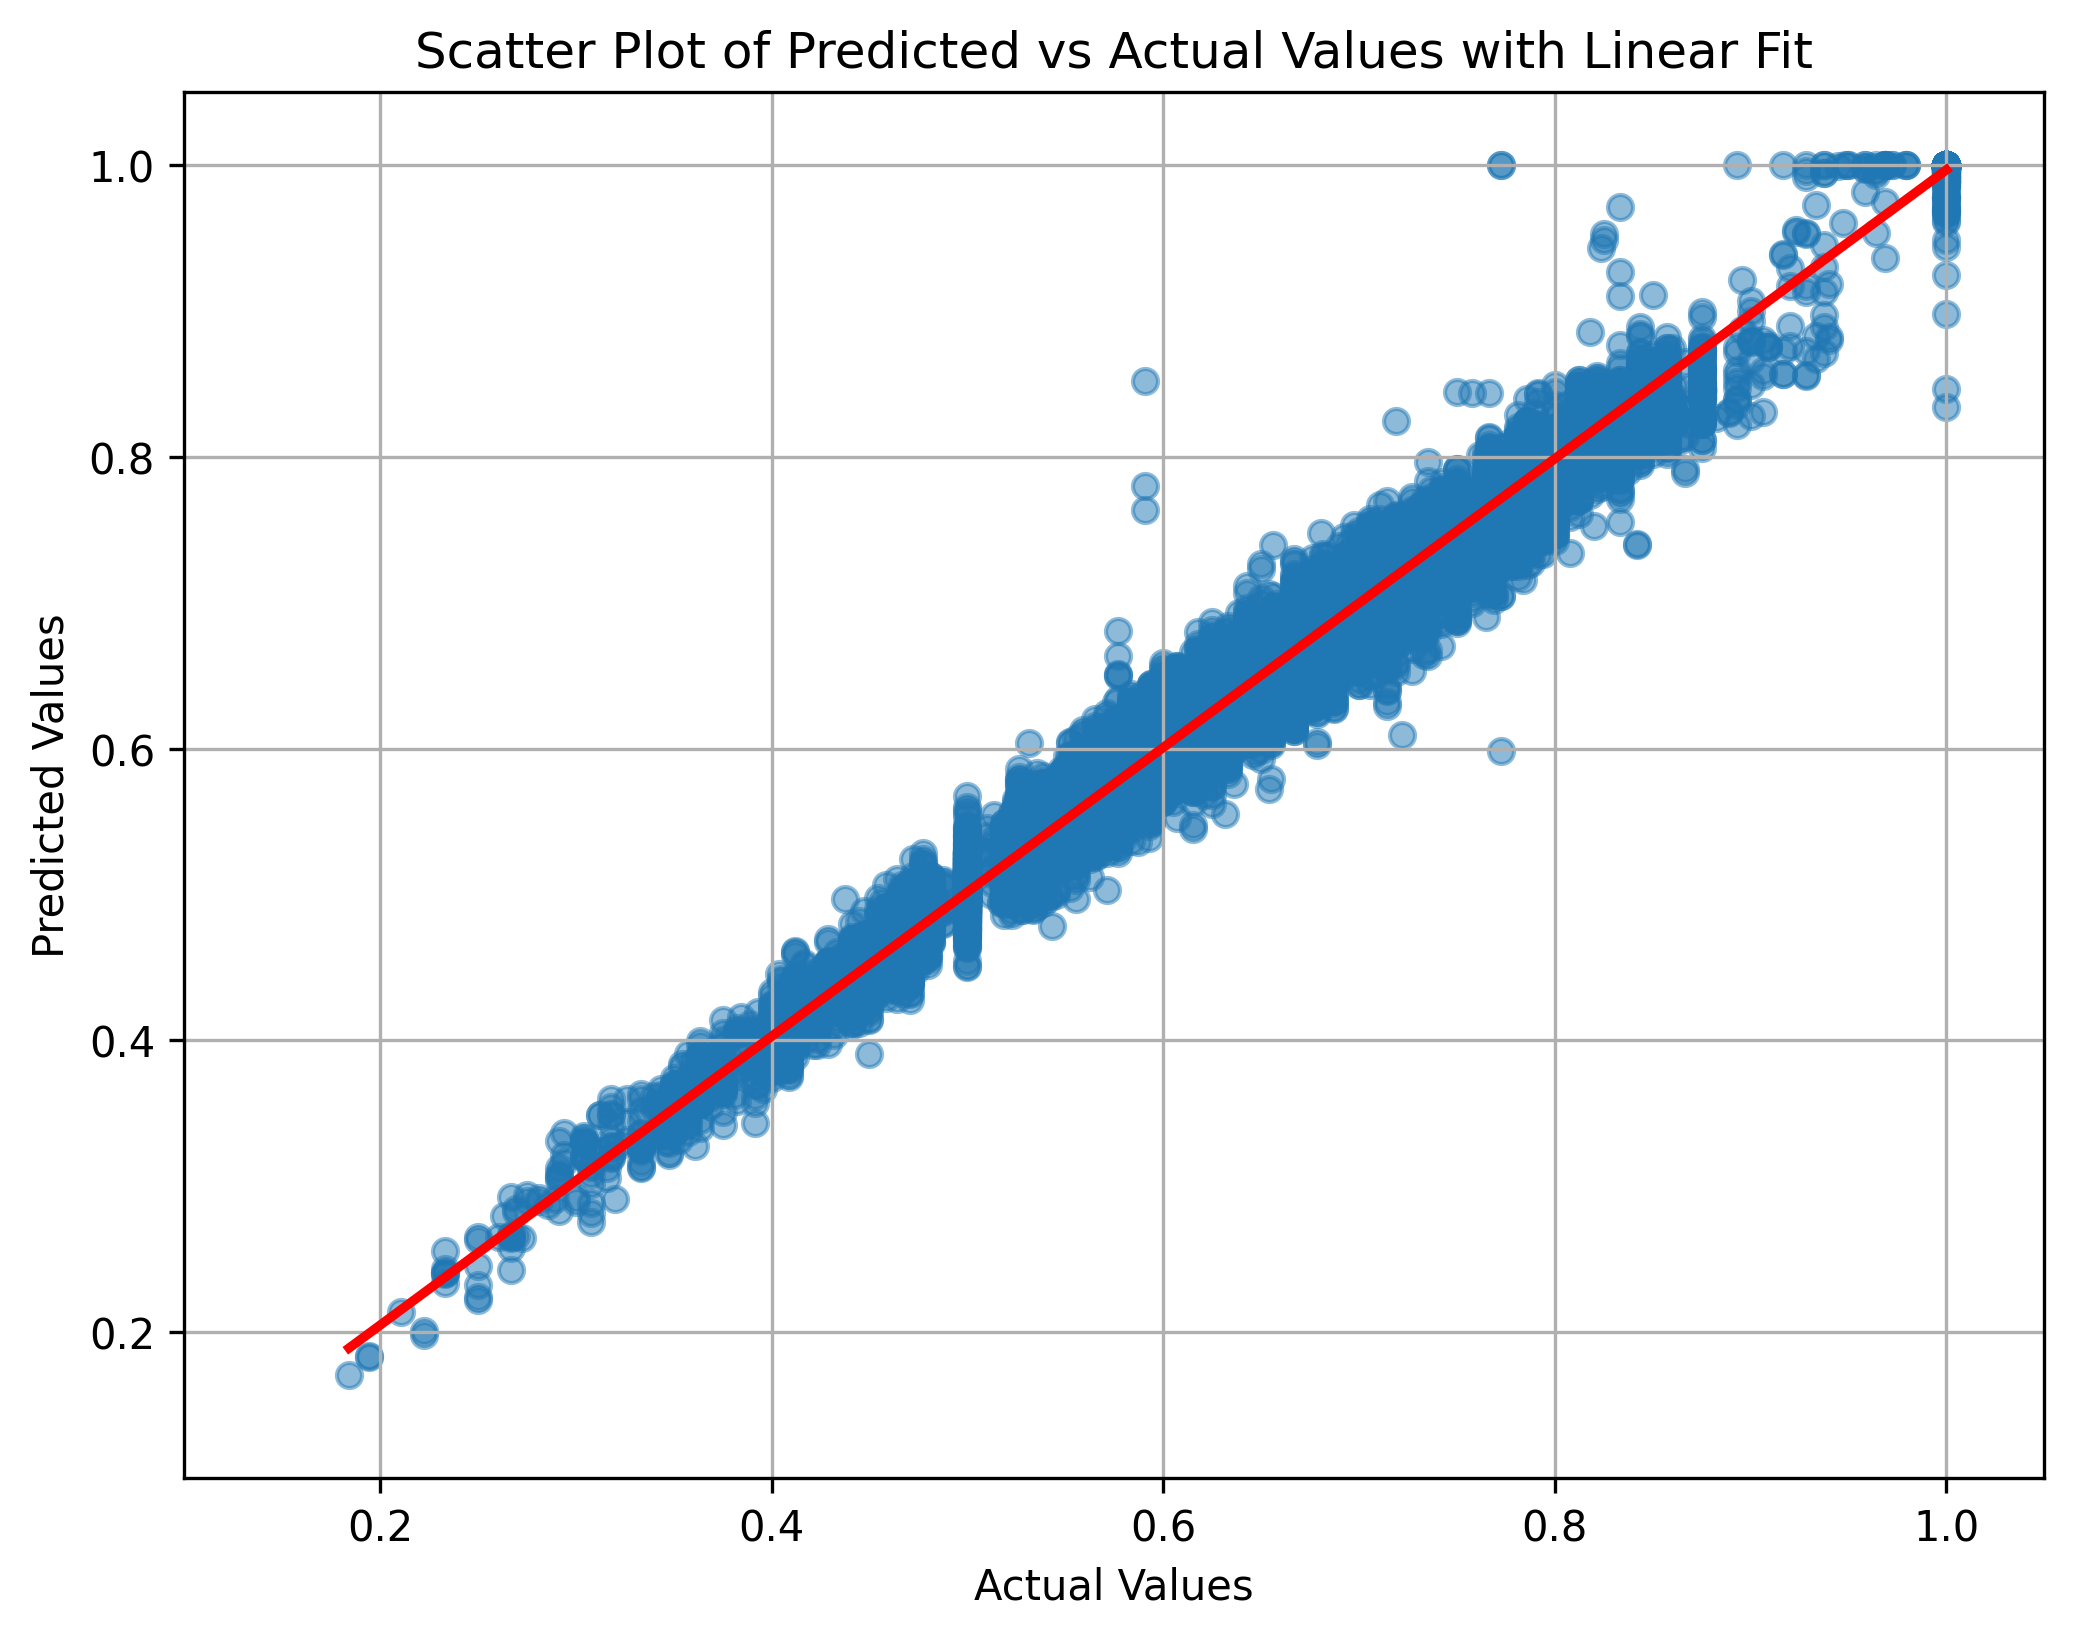

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# 绘制带线性拟合的散点图
fig = plt.figure(figsize=(8, 6), dpi=300)
sns.regplot(x=all_targets, y=all_preds, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Scatter Plot of Predicted vs Actual Values with Linear Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(0.1, 1.05)
plt.ylim(0.1, 1.05)
plt.grid(True)
plt.show()
fig.savefig('prediction_results.pdf', dpi=300)

In [11]:
from scipy.stats import pearsonr, spearmanr
pearsonr(all_preds, all_targets), spearmanr(all_preds, all_targets)

(PearsonRResult(statistic=0.9945332650960372, pvalue=0.0),
 SignificanceResult(statistic=0.9846208003870622, pvalue=0.0))

In [12]:
torch.save(model.state_dict(), "GA_GCN.pth")